In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import LSTM, Dropout, Dense,BatchNormalization,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

LOAD DATA

In [3]:
df=pd.read_csv(r"C:\Users\Sonu\Desktop\red_electrica\red-electrica\data\df_train_Photovoltaic_EXTREMADURA.csv",sep=';')

In [4]:
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df=df.rename(columns={'Timestamp':'Time'})
# df_2021 = df[(df['Time'].dt.year == 2021) & (df['Time'].dt.month == 1)].reset_index(drop=True)
df['ratio']=df['Measured energy production (MWh)']/df['Installed power (MW)']
df['Measured energy production (MWh)'] = df['Measured energy production (MWh)'].apply(lambda x: 0 if x < 10 else x)

In [5]:
df.describe()

,Measured energy production (MWh),Installed power (MW),ratio
count,17517.000000,17517.000000,17517.000000
mean,608.501993,2610.657704,0.227282
std,846.094652,699.209046,0.298144
min,0.000000,1418.380000,0.000006
25%,0.000000,2076.670000,0.000364
50%,32.610000,2850.550000,0.012516
75%,1129.930000,3313.780000,0.486861
max,3188.050000,3485.210000,0.968887


In [6]:
df[df['Measured energy production (MWh)']>=1].describe()

,Measured energy production (MWh),Installed power (MW),ratio
count,9516.000000,9516.000000,9516.000000
mean,1120.127093,2650.240240,0.417839
std,862.959302,688.442422,0.290046
min,10.000000,1418.380000,0.002937
25%,302.225000,2076.670000,0.128060
50%,1020.220000,2850.550000,0.441616
75%,1821.105000,3413.340000,0.677157
max,3188.050000,3485.210000,0.968887


(array([8001.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

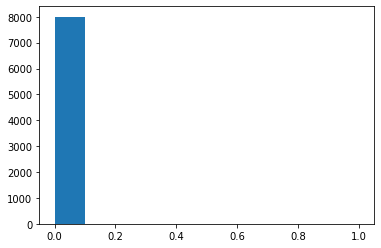

In [7]:
plt.hist(df['Measured energy production (MWh)'], range=(0, 1))

In [8]:
# plt.figure(figsize=(15,10))
# plt.plot(df['Time'],df['ratio'])

In [9]:
df.columns

Index(['Time', 'Measured energy production (MWh)', 'Installed power (MW)',
       'ratio'],
      dtype='object')

In [10]:
df.describe()

,Measured energy production (MWh),Installed power (MW),ratio
count,17517.000000,17517.000000,17517.000000
mean,608.501993,2610.657704,0.227282
std,846.094652,699.209046,0.298144
min,0.000000,1418.380000,0.000006
25%,0.000000,2076.670000,0.000364
50%,32.610000,2850.550000,0.012516
75%,1129.930000,3313.780000,0.486861
max,3188.050000,3485.210000,0.968887


In [18]:
test_data_size=31*24
train_data=df[:-test_data_size]
test_data=df[len(train_data):]
y_train=train_data['Measured energy production (MWh)']
y_test=test_data['Measured energy production (MWh)']



In [19]:
train_data

,Time,Measured energy production (MWh),Installed power (MW),ratio
0,2020-09-01 00:00:00,0.00,1418.38,0.000296
1,2020-09-01 01:00:00,0.00,1418.38,0.000324
2,2020-09-01 02:00:00,0.00,1418.38,0.000254
3,2020-09-01 03:00:00,0.00,1418.38,0.000324
4,2020-09-01 04:00:00,0.00,1418.38,0.000324
...,...,...,...,...
16768,2022-07-31 19:00:00,89.88,3485.21,0.025789
16769,2022-07-31 20:00:00,0.00,3485.21,0.000155
16770,2022-07-31 21:00:00,0.00,3485.21,0.000448
16771,2022-07-31 22:00:00,0.00,3485.21,0.000445


PROPHET

In [20]:

#Fbprophet--------------------

from prophet import Prophet

prophet_train_df =pd.DataFrame({'ds':train_data['Time'],'y':y_train})
prophet_train_df.columns = ['ds', 'y']

prophet = Prophet(seasonality_mode='multiplicative',
                  daily_seasonality=True,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  changepoint_prior_scale= 0.1,
                  )
prophet.fit(prophet_train_df)

future_df = prophet.make_future_dataframe(periods=len(y_test), freq='H')
prophet_forecast = prophet.predict(future_df)



15:11:19 - cmdstanpy - INFO - Chain [1] start processing
15:11:41 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
prophet_predictions = prophet_forecast['yhat'].iloc[-len(y_test):]
prophet_predictions=prophet_predictions.reset_index(drop=True)
prophet_predictions=prophet_predictions-[50]*len(y_test)
prophet_predictions = np.where(prophet_predictions < 0, 0, prophet_predictions)




In [22]:

def calculate_mape(actual, predicted):
        actual_nonzero_mask = actual != 0
        absolute_error = np.abs(actual[actual_nonzero_mask] - predicted[actual_nonzero_mask])
        mape = np.mean(absolute_error / actual[actual_nonzero_mask]) * 100
        return mape
mape = calculate_mape(y_test, prophet_predictions)
mse = mean_squared_error(y_test, prophet_predictions)
mae = mean_absolute_error(y_test, prophet_predictions)
print(f'mae={mae}, rmse={mse}, mape={mape}')

mae=151.9220039721548, rmse=82106.2902009839, mape=39.592237527921895


In [23]:
preddf = pd.DataFrame({
    'Time': test_data['Time'],
    'actual': y_test,
    'prophetpred': prophet_predictions
})

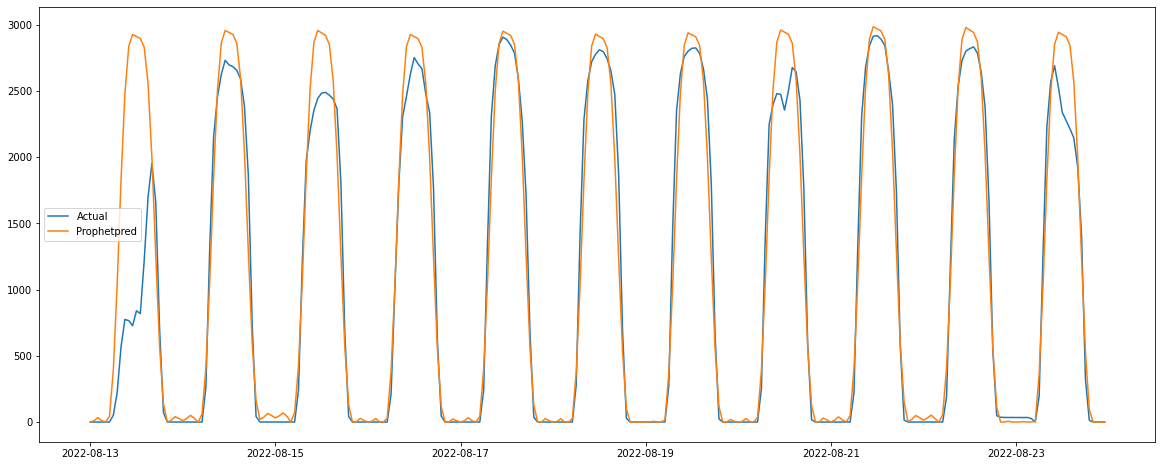

In [24]:
subset1=preddf[(preddf['Time'].dt.day>=13) & (preddf['Time'].dt.day<=23)]
plt.figure(figsize=(20,8))
plt.plot(subset1['Time'],subset1['actual'],label='Actual')
plt.plot(subset1['Time'],subset1['prophetpred'],label='Prophetpred')
plt.legend()

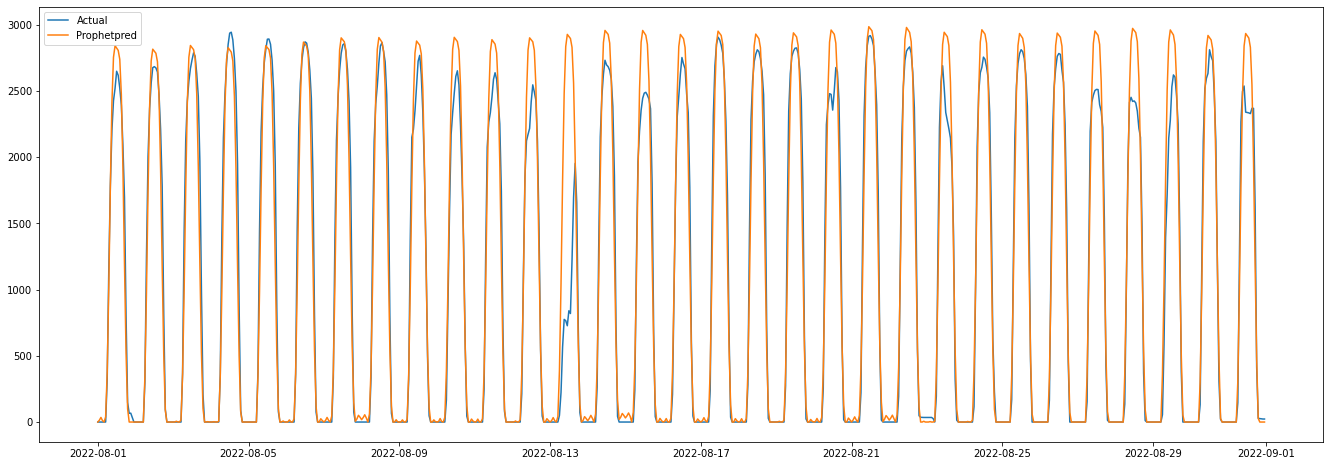

In [26]:
plt.figure(figsize=(23,8))
plt.plot(preddf['Time'],preddf['actual'],label='Actual')
plt.plot(preddf['Time'],preddf['prophetpred'],label='Prophetpred')
plt.legend()

MULTIVARIATE- LSTM

In [535]:
# NEW FEATURES
df.set_index('Time',inplace=True)
df['year']=df.index.year
df['month']=df.index.month 
df['day']=df.index.day 
df['hour']=df.index.hour 
df['newtime']=df.index.astype(int)/ (3600*10**9)
df

,Measured energy production (MWh),Installed power (MW),ratio,year,month,day,hour,newtime
Time,,,,,,,,
2020-09-01 00:00:00,0.00,1418.38,0.000296,2020,9,1,0,444144.0
2020-09-01 01:00:00,0.00,1418.38,0.000324,2020,9,1,1,444145.0
2020-09-01 02:00:00,0.00,1418.38,0.000254,2020,9,1,2,444146.0
2020-09-01 03:00:00,0.00,1418.38,0.000324,2020,9,1,3,444147.0
2020-09-01 04:00:00,0.00,1418.38,0.000324,2020,9,1,4,444148.0
...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,29.24,3485.21,0.008390,2022,8,31,19,461659.0
2022-08-31 20:00:00,25.88,3485.21,0.007426,2022,8,31,20,461660.0
2022-08-31 21:00:00,23.91,3485.21,0.006860,2022,8,31,21,461661.0


In [536]:
df.corr()

,Measured energy production (MWh),Installed power (MW),ratio,year,month,day,hour,newtime
Measured energy production (MWh),1.000000,0.254278,0.953162,0.258802,-0.061652,0.003484,0.066427,0.277072
Installed power (MW),0.254278,1.000000,0.076152,0.914679,-0.228109,0.044381,-0.000007,0.976758
ratio,0.953162,0.076152,1.000000,0.100708,-0.033363,-0.005327,0.069232,0.102604
year,0.258802,0.914679,0.100708,1.000000,-0.561636,-0.001706,-0.000027,0.910266
month,-0.061652,-0.228109,-0.033363,-0.561636,1.000000,0.011836,0.000062,-0.170431
day,0.003484,0.044381,-0.005327,-0.001706,0.011836,1.000000,0.000027,0.045510
hour,0.066427,-0.000007,0.069232,-0.000027,0.000062,0.000027,1.000000,0.001369
newtime,0.277072,0.976758,0.102604,0.910266,-0.170431,0.045510,0.001369,1.000000


In [561]:
from sklearn.preprocessing import MinMaxScaler
test_data_size=31*24
test_data = df[-test_data_size:]
look_back = 25
temp = df
dataset = temp[['Measured energy production (MWh)','Installed power (MW)','newtime']]
dataset = np.reshape(np.array(dataset), (-1, 3))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = test_data_size+look_back+1
train = dataset[:len(dataset) - test_size, :]
test = dataset[len(train):, :]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0]) 
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2], X_test.shape[1]))


In [539]:
X_train.shape


(16721, 3, 25)

In [572]:

def get_model():
    model = Sequential()
    model.add(LSTM(100, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))  
    model.add(Dropout(0.2)) 
    # model.add(BatchNormalization())
    # model.add(Dense(32,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# n_outputs=1
def get_modelcnn():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),padding='same'))
    # model.add(Conv1D(filters=64, kernel_size=3, activation='relu',padding='same'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# callbacks = [
#     ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
#     EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, mode='min', verbose=1)
# ]
# model=get_model()
model=get_model()


In [541]:
# history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_test, Y_test), callbacks=callbacks, verbose=1, shuffle=False)
# model.summary()
history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test),verbose=1, shuffle=False)
model.summary()

Epoch 1/200
262/262 [==============================] - 7s 11ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 2/200
262/262 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 3/200
262/262 [==============================] - 3s 11ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 4/200
262/262 [==============================] - 3s 12ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/200
262/262 [==============================] - 3s 11ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 6/200
262/262 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 7/200
262/262 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/200
262/262 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/200
262/262 [==============================] - 3s 10ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 10/200
262/262 [==============================] - 3s 10ms/step - loss: 0.0021 - 

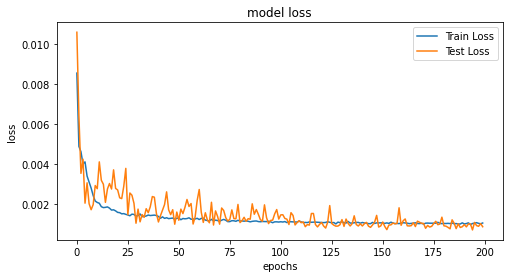

In [542]:
def get_curve(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    # plt.savefig('plot.jpg')
    plt.show()
get_curve(history)

AUG-2022 PREDICTIONS

In [543]:

# train_predict = model.predict(X_train)
# train_predict = scaler.inverse_transform(train_predict)
# train_predict=train_predict.flatten()
# Y_train = scaler.inverse_transform([Y_train])
# Y_train=Y_train.flatten()


In [544]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(np.hstack((test_predict, [[0]]*len(test_predict),[[0]]*len(test_predict))))[:,0]
test_predict=test_predict.flatten()
test_predict = np.where(test_predict < 0, 0, test_predict)
Y_test = scaler.inverse_transform(np.hstack((Y_test.reshape(-1,1), [[0]]*len(Y_test),[[0]]*len(Y_test))))[:,0]
Y_test=Y_test.flatten()


24/24 [==============================] - 9s 4ms/step


In [545]:

def metric(actual, pred):
    mape = calculate_mape(actual, pred)
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    return mape,mse,mae

# train_mape,train_mse,train_mae=metric(Y_train,train_predict)
test_mape,test_mse,test_mae=metric(Y_test,test_predict)

#print(f"train_mape:{train_mape},train_mse:{train_mse}, train_mae:{train_mae}\n")
print(f"test_mape:{test_mape},test_mse:{test_mse}, test_mae:{test_mae}")


test_mape:16.378865635319617,test_mse:8505.324838481994, test_mae:52.94491512559218


In [546]:
lstmdf = pd.DataFrame({
    'Time': test_data.reset_index()['Time'],
    'actual': Y_test,
    'LSTMpred': test_predict
})


In [547]:
Y_test.shape

(744,)

AUGUST MONTH PREDICTIONS

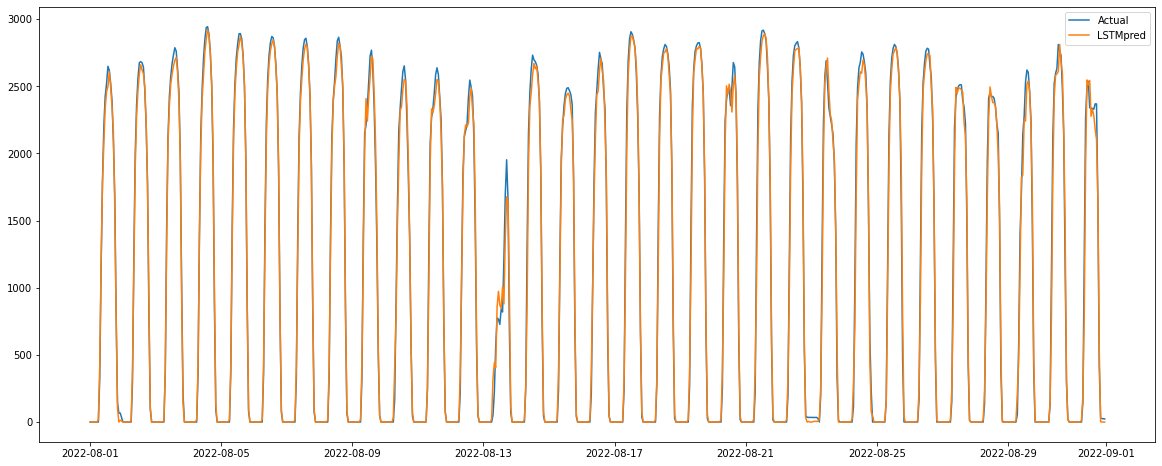

In [548]:
subset1=lstmdf[(lstmdf['Time'].dt.month==8)]
plt.figure(figsize=(20,8))
plt.plot(subset1['Time'],subset1['actual'],label='Actual')
plt.plot(subset1['Time'],subset1['LSTMpred'],label='LSTMpred')
plt.legend()

In [27]:
subset2=lstmdf[(lstmdf['Time'].dt.day>=13) & (lstmdf['Time'].dt.day<=23)]
plt.figure(figsize=(20,8))
plt.plot(subset2['Time'],subset2['actual'],label='Actual')
plt.plot(subset2['Time'],subset2['LSTMpred'],label='LSTMpred')
plt.legend()

NameError: name 'lstmdf' is not defined